In [2]:
import linearsolver as ls
import numpy as np
import matplotlib.pyplot as plt


n = 200
A_ = np.random.normal(size=(n**2)).reshape(n, n)
A = A_.T @ A_
# A = np.array(
#     [
#         [3, 0, -1, -1, 0, -1],
#         [0, 2, 0, -1, 0, 0],
#         [-1, 0, 3, 0, -1, 0],
#         [-1, -1, 0, 2, 0, -1],
#         [0, 0, -1, 0, 3, 1],
#         [-1, 0, 0, -1, -1, 4],
#     ],
#     dtype=float,
# )

x = np.random.normal(size=n)
x0 = np.random.normal(size=n)
b = A @ x
print(np.linalg.cond(A))
x_cg, res = ls.conjGrad(A, x0, b, 1e-7, 3*n, True)
((x_cg - x)**(2)).mean()

331681.21439688123
Condition number of A: 331681.21439688123
It:    20, ||r|| = 22.602907943751468
It:    40, ||r|| = 3.412506516156617
It:    60, ||r|| = 2.775768915543595
It:    80, ||r|| = 1.1340406218899428
It:   100, ||r|| = 0.3454035458571782
It:   120, ||r|| = 0.12036405118164364
It:   140, ||r|| = 0.10746641409499673
It:   160, ||r|| = 0.06918093870842962
It:   180, ||r|| = 0.08928091338915664
It:   200, ||r|| = 0.10016977323388353
It:   220, ||r|| = 0.07762522773216692
It:   240, ||r|| = 0.02065544506664054
It:   260, ||r|| = 0.03258691311490813
It:   280, ||r|| = 0.11852687946011589
It:   300, ||r|| = 0.046323392939458176
It:   320, ||r|| = 0.022366284639085098
It:   340, ||r|| = 0.002355413256074954
It:   360, ||r|| = 1.6911831588842517e-07
It:   363, ||r|| = 8.346148306020394e-08


2.223119557058336e-20

## Deflation

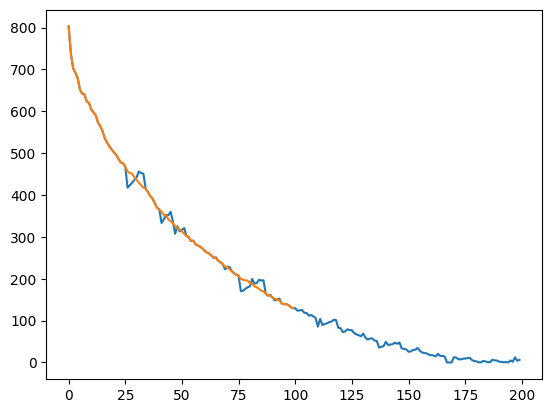

In [3]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]

w, v = np.linalg.eig(A)
plt.plot(w)
plt.plot(Sr)

In [4]:
def proj(Ur, Sr):
    projector = Ur @ Ur.T
    sec = Ur @ np.diag(Sr**(-1)) @ Ur.T
    return projector, sec

pi_A,  pi_U = proj(Ur, Sr)
maxiter=  10*n
second_term = pi_U @ b
pi_A_orth = np.eye(n) - pi_A
A_matrix = A @ pi_A_orth
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
x_cg_def_lhs = ls.solve_cg(A_matrix, pi_A_orth.T @ b, maxiter=maxiter, verbose=True)[0]
x_cg_def = pi_A_orth @ x_cg_def_lhs + pi_U @ b
print(((x_cg_def - x_cg_baseline)**2).sum())

Condition number of A: 331681.21439688123
It:    20, ||r|| = 14.96081291167285
It:    40, ||r|| = 1.6888741679398653
It:    60, ||r|| = 1.1663357882901395
It:    80, ||r|| = 0.7957806775812496
It:   100, ||r|| = 0.368663776693985
It:   120, ||r|| = 0.2143577145944234
It:   140, ||r|| = 0.18001460333426583
It:   160, ||r|| = 0.09692190828733234
It:   180, ||r|| = 0.12485862672587428
It:   200, ||r|| = 0.17034819987420508
It:   220, ||r|| = 0.05753625979620481
It:   240, ||r|| = 0.017287007425119474
It:   260, ||r|| = 0.02319389986302739
It:   280, ||r|| = 0.00865670264972952
It:   300, ||r|| = 0.004488626725404802
It:   320, ||r|| = 0.013410593093977937
It:   340, ||r|| = 0.001732110593477151
It:   360, ||r|| = 1.3897061444208694e-07
It:   369, ||r|| = 9.016150698458904e-09
Condition number of A: 1.9484584601291702e+17
It:    20, ||r|| = 0.9024200988730305
It:    40, ||r|| = 0.2983388741163294
It:    60, ||r|| = 0.1047943729328654
It:    80, ||r|| = 0.12829436912838435
It:   100, ||r|| 

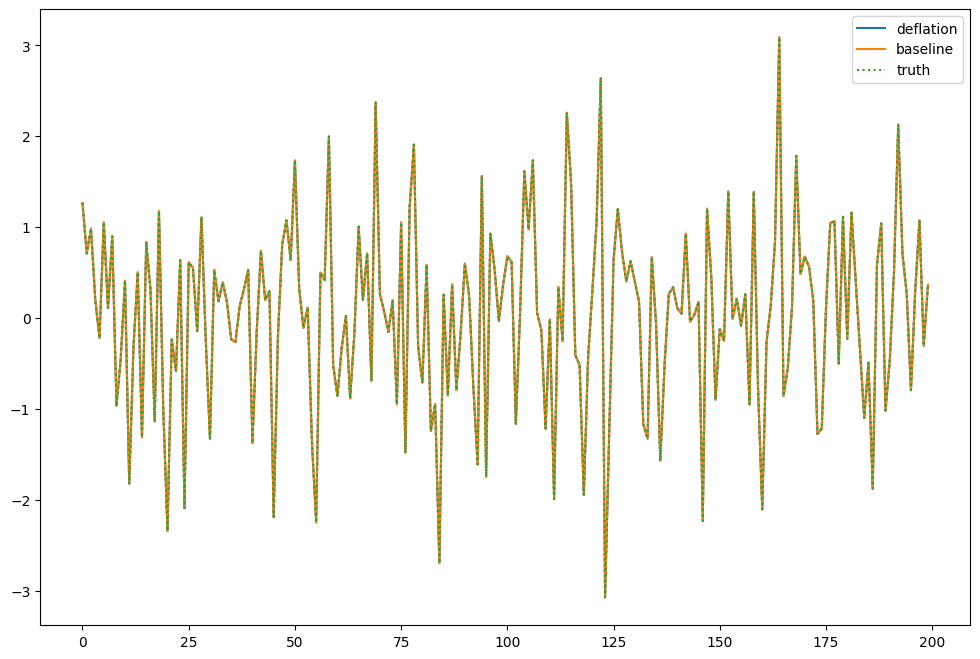

In [5]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_def, label='deflation')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [6]:
print(f"{(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=}")
print(f"{(pi_A @ x - pi_U @ b).max()=}")

(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=1.060963539245563e-10
(pi_A @ x - pi_U @ b).max()=2.3314683517128287e-15


## LMP ?

In [7]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]

In [34]:
def sum_lmp_spectral(S, U, r):
    acc = np.zeros((n,n))
    for i in range(r):
        acc += (1- (1/S[i])) * U[:, i].reshape(n, 1) @ U[:, i].reshape(1, n)
    return np.eye(n) - acc


In [36]:
H_r = sum_lmp_spectral(S, U, r)
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
x_cg_lmp = ls.solve_cg(H_r @ A, H_r @ b, maxiter=maxiter, verbose=True)[0]

Condition number of A: 331681.21439688123
It:    20, ||r|| = 14.96081291167285
It:    40, ||r|| = 1.6888741679398653
It:    60, ||r|| = 1.1663357882901395
It:    80, ||r|| = 0.7957806775812496
It:   100, ||r|| = 0.368663776693985
It:   120, ||r|| = 0.2143577145944234
It:   140, ||r|| = 0.18001460333426583
It:   160, ||r|| = 0.09692190828733234
It:   180, ||r|| = 0.12485862672587428
It:   200, ||r|| = 0.17034819987420508
It:   220, ||r|| = 0.05753625979620481
It:   240, ||r|| = 0.017287007425119474
It:   260, ||r|| = 0.02319389986302739
It:   280, ||r|| = 0.00865670264972952
It:   300, ||r|| = 0.004488626725404802
It:   320, ||r|| = 0.013410593093977937
It:   340, ||r|| = 0.001732110593477151
It:   360, ||r|| = 1.3897061444208694e-07
It:   369, ||r|| = 9.016150698458904e-09
Condition number of A: 53516.52298829704
It:    20, ||r|| = 2.3449933355630113
It:    40, ||r|| = 0.3150096700569465
It:    60, ||r|| = 0.11295514793161
It:    80, ||r|| = 0.15577508795311493
It:   100, ||r|| = 0.009

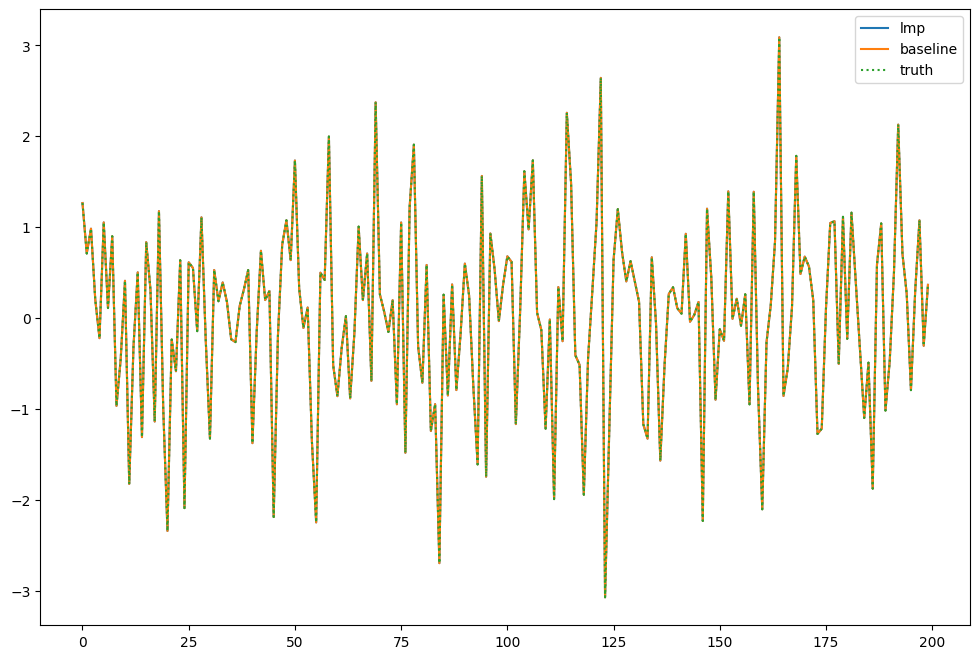

In [37]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_lmp, label='lmp')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [21]:
U[:, i].reshape(n, 1) @ U[:, i].reshape(n, 1).T

array([[ 0.00296667, -0.01110097, -0.00121956, ...,  0.00239172,
         0.00236951, -0.00074564],
       [-0.01110097,  0.04153863,  0.00456348, ..., -0.00894958,
        -0.00886645,  0.00279009],
       [-0.00121956,  0.00456348,  0.00050135, ..., -0.00098321,
        -0.00097408,  0.00030652],
       ...,
       [ 0.00239172, -0.00894958, -0.00098321, ...,  0.0019282 ,
         0.00191029, -0.00060113],
       [ 0.00236951, -0.00886645, -0.00097408, ...,  0.00191029,
         0.00189255, -0.00059555],
       [-0.00074564,  0.00279009,  0.00030652, ..., -0.00060113,
        -0.00059555,  0.00018741]])